In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

In [2]:
AWS_URL = "https://noaa-ghcn-pds.s3.amazonaws.com/csv/by_year/2023.csv"

def load_noaa_data(url):
    print("Fetching NOAA climate data from AWS S3")
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(io.StringIO(response.text))
        print("Data loaded")
        return df
    else:
        print("Failed to fetch data")
        return None

df = load_noaa_data(AWS_URL)


Fetching NOAA climate data from AWS S3
Data loaded


In [3]:
# get and normalize the temperatures
df = df[df["ELEMENT"] == "TAVG"]
df["TEMP_C"] = df["DATA_VALUE"] / 10

# convert date into year and month
df["Year"] = df["DATE"].astype(str).str[:4].astype(int)
df["Month"] = df["DATE"].astype(str).str[4:6].astype(int)

# only get relevant cols
df = df[["ID", "Year", "Month", "TEMP_C"]]
df.columns = ["Station_ID", "Year", "Month", "Temperature"]

In [4]:
df.head()

,Station_ID,Year,Month,Temperature
12,ASN00007176,2023,1,35.6
71,AE000041196,2023,1,20.7
75,AEM00041194,2023,1,22.3
78,AEM00041217,2023,1,21.5
81,AEM00041218,2023,1,19.3


In [5]:
df.describe()

,Year,Month,Temperature
count,2267515.0,2.267515e+06,2.267515e+06
mean,2023.0,6.516843e+00,1.097210e+01
std,0.0,3.462023e+00,1.331714e+01
min,2023.0,1.000000e+00,-8.130000e+01
25%,2023.0,3.000000e+00,2.100000e+00
50%,2023.0,7.000000e+00,1.240000e+01
75%,2023.0,1.000000e+01,2.100000e+01
max,2023.0,1.200000e+01,4.822000e+02


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2267515 entries, 12 to 37856682
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Station_ID   object 
 1   Year         int64  
 2   Month        int64  
 3   Temperature  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 86.5+ MB


<Axes: >

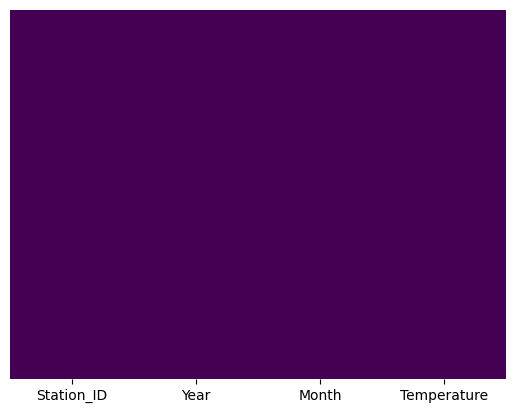

In [7]:
# null data heatmap
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

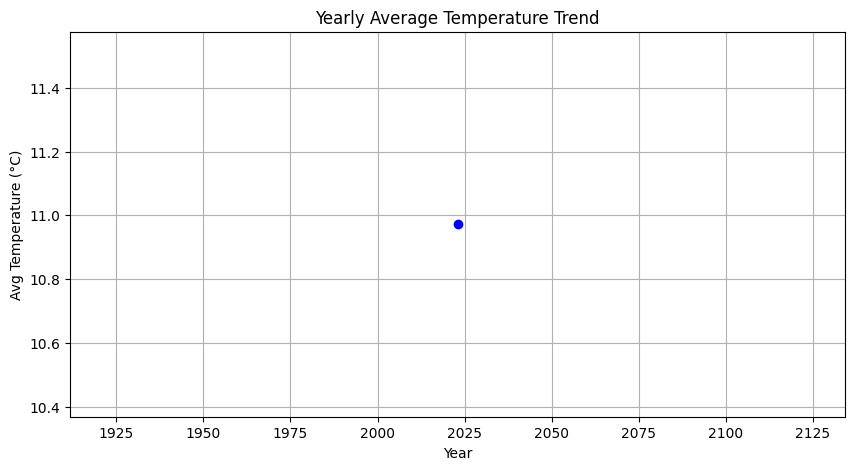

In [8]:
# yearly average temperature trends
df_yearly_avg = df.groupby("Year")["Temperature"].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_yearly_avg["Year"], df_yearly_avg["Temperature"], marker="o", linestyle="-", color="b")
plt.xlabel("Year")
plt.ylabel("Avg Temperature (°C)")
plt.title("Yearly Average Temperature Trend")
plt.grid()
plt.show()

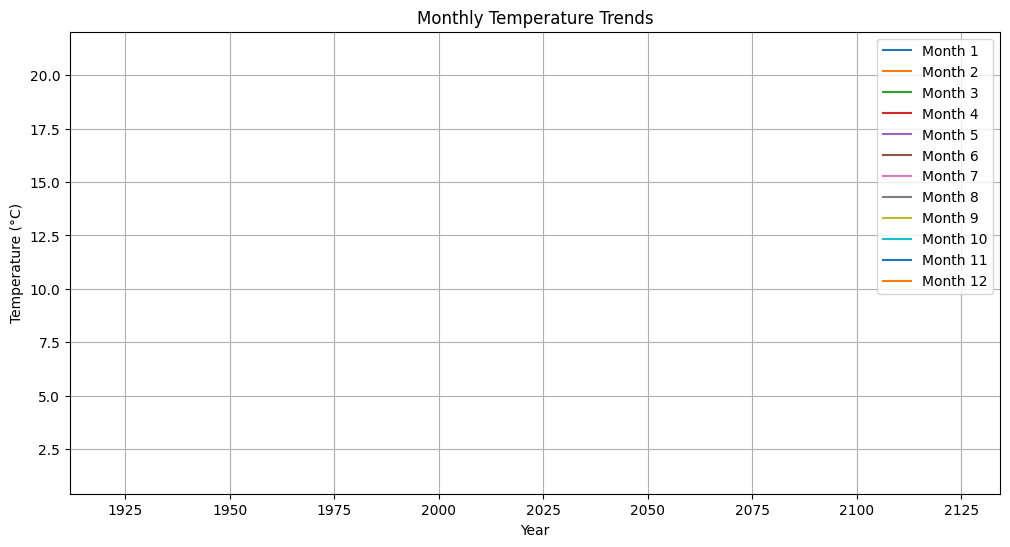

In [9]:
# monthly average temperature trends
df_melted = df.pivot_table(index="Year", columns="Month", values="Temperature", aggfunc="mean")

plt.figure(figsize=(12, 6))
for month in range(1, 13):
    plt.plot(df_melted.index, df_melted[month], label=f"Month {month}")

plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.title("Monthly Temperature Trends")
plt.legend()
plt.grid()
plt.show()
